In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

### get experiments to analyze

The VBA <code>data_access</code> module provides useful functions for identifying and loading experiments to analyze. 

In [3]:
import visual_behavior.data_access.loading as loading

The <code>get_filtered_ophys_experiment_table()</code> function returns a table describing passing ophys experiments from relevant project codes (aka the manifest)

In [4]:
experiments_table = loading.get_filtered_ophys_experiment_table() 

In [5]:
experiments_table.head()

,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,...,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
953659745,952430817,952554548,1018028339,VisualBehaviorMultiscope,completed,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,...,NaN,850862430,Sst-IRES-Cre,NaN,"z_drift_corr_um_diff,z_drift_corr_um_diff,z_dr...",0,False,Sst_VISp_75,True,2
953659749,952430817,952554548,1018028354,VisualBehaviorMultiscope,completed,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,...,NaN,850862430,Sst-IRES-Cre,NaN,"z_drift_corr_um_diff,z_drift_corr_um_diff,z_dr...",0,False,Sst_VISl_150,True,2
953659752,952430817,952554548,1018028357,VisualBehaviorMultiscope,completed,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,...,NaN,850862430,Sst-IRES-Cre,NaN,"z_drift_corr_um_diff,z_drift_corr_um_diff,z_dr...",0,False,Sst_VISl_225,True,2
953659743,952430817,952554548,1018028345,VisualBehaviorMultiscope,completed,passed,20190923_457841_2imagesA,OPHYS_2_images_A_passive,MESO.1,2019-09-23 08:13:07.627573,...,NaN,850862430,Sst-IRES-Cre,NaN,"z_drift_corr_um_diff,z_drift_corr_um_diff,z_dr...",0,False,Sst_VISp_225,True,2
958527474,954954402,953982960,1018028339,VisualBehaviorMultiscope,completed,passed,20190924_457841_3imagesA,OPHYS_3_images_A,MESO.1,2019-09-24 16:00:00.000000,...,NaN,850862430,Sst-IRES-Cre,NaN,NaN,0,True,Sst_VISp_75,True,3


In [6]:
# number of Scientifica experiments 
print(len(experiments_table[experiments_table.project_code.isin(['VisualBehavior', 'VisualBehaviorTask1B'])]))

307


In [7]:
# number of Mesoscope experiments 
print(len(experiments_table[experiments_table.project_code.isin(['VisualBehaviorMultiscope'])]))

750


In [8]:
# get some experiment
aribtrary_index = 699
ophys_experiment_id = experiments_table.index.values[aribtrary_index]

In [9]:
# see what metadata is available
experiments_table.iloc[aribtrary_index]

ophys_session_id                                                 993716877
behavior_session_id                                              993760890
container_id                                                     989461845
project_code                                          VisualBehaviorTask1B
container_workflow_state                                         completed
experiment_workflow_state                                           passed
session_name                                      20191211_485688_6imagesA
session_type                                              OPHYS_6_images_A
equipment_name                                                     CAM2P.3
date_of_acquisition                             2019-12-11 18:43:26.000000
isi_experiment_id                                                952686300
specimen_id                                                      940744053
sex                                                                      M
age_in_days              

In [10]:
# get all Vip experiments for the novel image set where it was not a retake 
# & has behavior model outputs and events available

experiments_to_analyze = experiments_table[(experiments_table.cre_line=='Vip-IRES-Cre')&
                 (experiments_table.session_number==4)&
                 (experiments_table.exposure_number==0)&
                 (experiments_table.model_outputs_available==True)&
                 (experiments_table.has_events==True)]
print(len(experiments_to_analyze))

16


### get SDK dataset through VBA loading function

The <code>get_ophys_dataset</code> function in <code>data_access.loading</code> returns an AllenSDK session object for a single imaging plane.

In [11]:
help(loading.get_ophys_dataset)

Help on function get_ophys_dataset in module visual_behavior.data_access.loading:

get_ophys_dataset(ophys_experiment_id, include_invalid_rois=False)
    Gets behavior + ophys data for one experiment (single imaging plane), using the SDK LIMS API, then reformats & filters to compensate for bugs and missing SDK features.
        This functionality should eventually be entirely replaced by the SDK when all requested features have been implemented.
    
    Arguments:
        ophys_experiment_id {int} -- 9 digit ophys experiment ID
        include_invalid_rois {Boolean} -- if True, return all ROIs including invalid. If False, filter out invalid ROIs
    
    Returns:
        BehaviorOphysDataset {object} -- BehaviorOphysDataset instance, inherits attributes & methods from SDK BehaviorOphysSession class



In [12]:
# this function gets an SDK session object then does a bunch of reformatting to fix things
dataset = loading.get_ophys_dataset(ophys_experiment_id, include_invalid_rois=False)

The dataset object has attributes for relevant datastreams including: <code>max_projection, dff_traces, running_speed, stimulus_presentations, and eye_tracking</code>

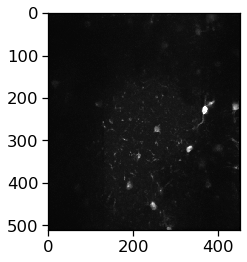

In [13]:
plt.imshow(dataset.max_projection, cmap='gray')

In [14]:
# get traces
dataset.dff_traces.head()

,cell_roi_id,dff
cell_specimen_id,,
992902634,993904442,"[0.40618523558985714, 0.2744984655847703, 0.27..."
992902619,993904447,"[0.2803432405393046, 0.1282977318955565, 0.226..."
992902622,993904448,"[0.16098961599561631, 0.24784887524716945, 0.2..."
992902667,993904449,"[0.12736352462795214, 0.1492638972337093, 0.08..."
992902649,993904450,"[0.33200911929641863, 0.3348382125510426, 0.29..."


In [16]:
# as an array if you prefer
dff_array = np.vstack(dataset.dff_traces.dff.values)
dff_array.shape

(11, 139956)

In [18]:
# get events (if this experiment has events)
dataset.events

getting L0 events


,events
cell_specimen_id,
992902610,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902619,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902622,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902634,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902649,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902655,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902661,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
992902691,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
# as an array
dataset.events_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.25237716,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.21273149, 0.        ,
        0.        ],
       [0.        , 0.19253862, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.4171323 , 0.        ,
        0.        ]])

In [20]:
# ophys timestamps
dataset.ophys_timestamps

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


array([2.78203000e+00, 2.81434000e+00, 2.84664000e+00, ...,
       4.52571353e+03, 4.52574585e+03, 4.52577817e+03])

In [21]:
# pick a cell
cell_specimen_ids = dataset.cell_specimen_ids
cell_specimen_id = cell_specimen_ids[5]

Text(0, 0.5, 'dF/F')

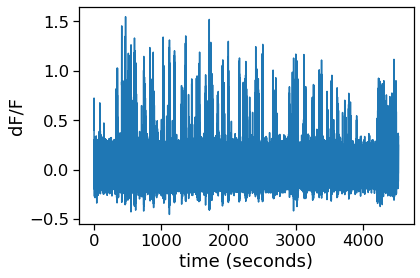

In [22]:
# plot its trace
plt.plot(dataset.ophys_timestamps, dataset.dff_traces.loc[cell_specimen_id, 'dff'])
plt.xlabel('time (seconds)')
plt.ylabel('dF/F')

Text(0, 0.5, 'run speed (cm/s)')

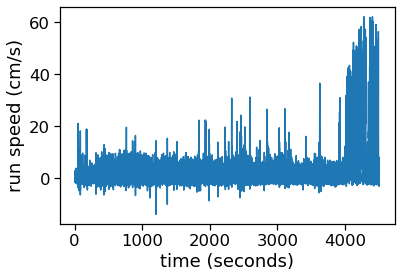

In [23]:
# plot running speed
plt.plot(dataset.stimulus_timestamps, dataset.running_speed['speed'])
plt.xlabel('time (seconds)')
plt.ylabel('run speed (cm/s)')

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam1_exposure', 'cam2_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


Text(0, 0.5, 'pupil width (pixels?)')

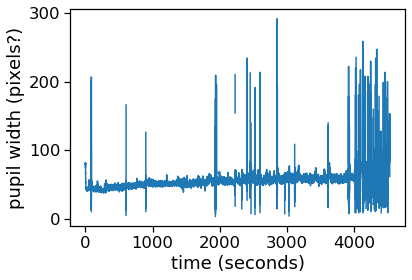

In [24]:
# plot pupil diameter
plt.plot(dataset.eye_tracking.time, dataset.eye_tracking.pupil_width)
plt.xlabel('time (seconds)')
plt.ylabel('pupil width (pixels?)')

In [25]:
# basic stimulus information
dataset.stimulus_presentations.head(10)

,duration,end_frame,image_index,image_name,omitted,start_frame,start_time,stop_time,change,epoch
stimulus_presentations_id,,,,,,,,,,
0,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0
1,0.25012,18046.0,0,im065,False,18031,306.621138,306.871258,False,0
2,0.24995,18091.0,0,im065,False,18076,307.371668,307.621618,False,0
3,0.25021,18136.0,0,im065,False,18121,308.121998,308.372208,False,0
4,0.25020,18181.0,0,im065,False,18166,308.872618,309.122818,False,0
5,0.25021,18226.0,0,im065,False,18211,309.623238,309.873448,False,0
6,0.25021,18271.0,0,im065,False,18256,310.373838,310.624048,False,0
7,0.25023,18316.0,0,im065,False,18301,311.124438,311.374668,False,0
8,0.25023,18361.0,0,im065,False,18346,311.875058,312.125288,False,0


In [26]:
dataset.stimulus_presentations.keys()

Index(['duration', 'end_frame', 'image_index', 'image_name', 'omitted',
       'start_frame', 'start_time', 'stop_time', 'change', 'epoch'],
      dtype='object')

In [27]:
# stimulus information with many extra columns including behavior model outputs
dataset.extended_stimulus_presentations.head(10)

,duration,end_frame,image_index,image_name,omitted,start_frame,start_time,stop_time,change,epoch,...,in_bout,bias,omissions1,task0,timing1D,engagement_state,lick_on_next_flash,lick_rate_next_flash,lick_on_previous_flash,lick_rate_previous_flash
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0,...,0,-2.844371,1.402563,2.857260,2.957705,disengaged,0.0,0.000000,NaN,NaN
1,0.25012,18046.0,0,im065,False,18031,306.621138,306.871258,False,0,...,0,-2.844370,1.402563,2.857261,2.957712,disengaged,1.0,0.148148,0.0,0.000000
2,0.24995,18091.0,0,im065,False,18076,307.371668,307.621618,False,0,...,0,-2.844354,1.402563,2.857263,2.957712,engaged,0.0,0.250000,0.0,0.000000
3,0.25021,18136.0,0,im065,False,18121,308.121998,308.372208,False,0,...,0,-2.845411,1.402563,2.857269,2.958198,engaged,0.0,0.266667,1.0,0.148148
4,0.25020,18181.0,0,im065,False,18166,308.872618,309.122818,False,0,...,0,-2.846455,1.402563,2.857275,2.958678,engaged,0.0,0.259259,0.0,0.250000
5,0.25021,18226.0,0,im065,False,18211,309.623238,309.873448,False,0,...,0,-2.847483,1.402563,2.857281,2.959151,engaged,0.0,0.244898,0.0,0.266667
6,0.25021,18271.0,0,im065,False,18256,310.373838,310.624048,False,0,...,0,-2.848487,1.402563,2.857287,2.959618,engaged,0.0,0.229167,0.0,0.259259
7,0.25023,18316.0,0,im065,False,18301,311.124438,311.374668,False,0,...,0,-2.849433,1.402563,2.857292,2.960087,engaged,0.0,0.213992,0.0,0.244898
8,0.25023,18361.0,0,im065,False,18346,311.875058,312.125288,False,0,...,0,-2.850263,1.402563,2.857297,2.960593,engaged,1.0,0.213333,0.0,0.229167


In [28]:
dataset.extended_stimulus_presentations.keys()

Index(['duration', 'end_frame', 'image_index', 'image_name', 'omitted',
       'start_frame', 'start_time', 'stop_time', 'change', 'epoch',
       'mean_running_speed', 'licks', 'rewards', 'time_from_last_lick',
       'time_from_last_reward', 'time_from_last_change',
       'time_from_last_omission', 'flash_after_omitted', 'flash_after_change',
       'licked', 'lick_rate', 'rewarded', 'reward_rate', 'running_rate',
       'bout_rate', 'hit_bout', 'hit_fraction', 'high_lick', 'high_reward',
       'flash_metrics_epochs', 'flash_metrics_labels', 'in_bout', 'bias',
       'omissions1', 'task0', 'timing1D', 'engagement_state',
       'lick_on_next_flash', 'lick_rate_next_flash', 'lick_on_previous_flash',
       'lick_rate_previous_flash'],
      dtype='object')

In [29]:
# behavioral trial information
dataset.trials.head(10)

,lick_times,reward_time,reward_volume,hit,false_alarm,miss,stimulus_change,aborted,go,catch,...,stop_time,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name,epoch,trial_type
trials_id,,,,,,,,,,,,,,,,,,,,,
0,[307.75030998569304],NaN,0.000,False,False,False,False,True,False,False,...,308.045598,2.234983,NaN,NaN,NaN,NaN,im065,im065,0,None
1,"[312.93787406089467, 313.13803840090236, 313.2...",312.716105,0.005,False,False,False,True,False,False,False,...,316.819476,8.757088,NaN,18390.0,312.625698,0.312176,im065,im077,0,auto_rewarded
2,[318.2588803467818],NaN,0.000,False,False,False,False,True,False,False,...,318.537877,1.468047,NaN,NaN,NaN,NaN,im077,im077,0,None
3,[322.2954893002551],NaN,0.000,False,False,False,False,True,False,False,...,322.590810,4.019530,NaN,NaN,NaN,NaN,im077,im077,0,None
4,"[328.8008103097004, 328.9342522278174, 329.034...",328.478966,0.005,False,False,False,True,False,False,False,...,332.582345,9.507704,NaN,19335.0,328.388538,0.412273,im077,im069,0,auto_rewarded
5,"[335.48959859681645, 335.7564853587146]",NaN,0.000,False,False,False,False,True,False,False,...,336.051792,3.219192,NaN,NaN,NaN,NaN,im069,im069,0,None
6,"[343.1461081960536, 343.32960853373703]",NaN,0.000,False,False,False,False,True,False,False,...,343.624603,7.038924,NaN,NaN,NaN,NaN,im069,im069,0,None
7,[345.24758903426266],NaN,0.000,False,False,False,False,True,False,False,...,345.542863,1.451042,NaN,NaN,NaN,NaN,im069,im069,0,None
8,"[352.8037252135534, 352.9538434217864, 353.053...",352.498601,0.005,False,False,False,True,False,False,False,...,356.601933,11.008894,NaN,20775.0,352.408158,0.395567,im069,im061,0,auto_rewarded


### ResponseAnalysis class provides access to time aligned cell responses for trials, stimuli, and omissions

VBA also has useful functionality for creating data frames with cell traces aligned to the time of stimulus presentations, omissions, or behavioral trials. 

In [30]:
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

In [31]:
help(ResponseAnalysis)

Help on class ResponseAnalysis in module visual_behavior.ophys.response_analysis.response_analysis:

class ResponseAnalysis(builtins.object)
 |  ResponseAnalysis(dataset, analysis_cache_dir=None, load_from_cache=False, use_events=False, use_extended_stimulus_presentations=False, overwrite_analysis_files=False, dataframe_format='wide')
 |  
 |  Contains methods for organizing cell responses by trials, stimulus presentations, or omissions in a DataFrame.
 |  
 |  For each trial, stimulus presentation, or omission, a segment of the dF/F trace (or events if available and use_events=True) is extracted for each cell aligned to the time of the relevant event (ex: at the change time for each trial).
 |  The duration of each trace segment is a window around the event time, with default values for trials = [-5,5], stimulus presentations = [-0.5,0.75], and omissions = [-5,5].
 |  The mean_response for each cell is taken in a 500ms window after the change time or stimulus onset time, or in a 750ms

In [32]:
# initialize class
analysis = ResponseAnalysis(dataset, # provide dataset object
                            use_events=False, # set to True if you want events
                            use_extended_stimulus_presentations=False) # set to True if you want extra columns  

### Get cell traces for all stimulus presentations 

In [33]:
# this creates a dataframe with the response of every cell for every stimulus presentation
# cell response is a snippet of the trace in a [-.5, 0.75] second window around stim onset
stim_response_df = analysis.get_response_df(df_name='stimulus_response_df')

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [34]:
stim_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,p_value_omission,p_value_stimulus,duration,end_frame,image_index,image_name,omitted,start_frame,start_time,stop_time,change,epoch
0,0,992902634,"[0.030777270517727537, -0.028265900667685907, ...","[-0.4847625458182987, -0.4524450427637455, -0....",0.025579,-0.017779,0.0932,0.0314,0.2594,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0
1,0,992902619,"[-0.09817557571738311, -0.0614228314889473, -0...","[-0.4847625458182987, -0.4524450427637455, -0....",0.025675,0.072043,0.1705,0.1269,0.1775,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0
2,0,992902622,"[0.0001706995323889418, -0.12157291399546681, ...","[-0.4847625458182987, -0.4524450427637455, -0....",0.016921,-0.019611,0.2379,0.0639,0.4315,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0
3,0,992902667,"[-0.009855721190371858, 0.0304049021414319, 0....","[-0.4847625458182987, -0.4524450427637455, -0....",0.005435,0.021681,0.3806,0.1978,0.4960,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0
4,0,992902649,"[-0.06964146566402062, 0.06743697233314155, -0...","[-0.4847625458182987, -0.4524450427637455, -0....",-0.010310,-0.052846,0.7312,0.4444,0.8052,0.25022,18001.0,0,im065,False,17986,305.870178,306.120398,False,0


In [35]:
stim_response_df.keys() 

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response',
       'p_value_gray_screen', 'p_value_omission', 'p_value_stimulus',
       'duration', 'end_frame', 'image_index', 'image_name', 'omitted',
       'start_frame', 'start_time', 'stop_time', 'change', 'epoch'],
      dtype='object')

#### plot single trial response for some cell

Text(0, 0.5, 'dF/F')

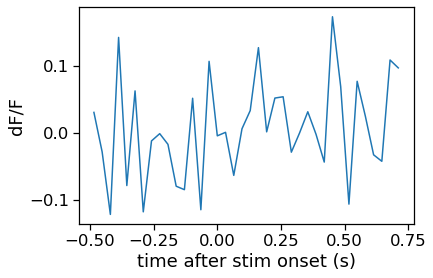

In [36]:
cell_specimen_id = stim_response_df.cell_specimen_id.unique()[0]

trace = stim_response_df[stim_response_df.cell_specimen_id==cell_specimen_id].trace.values[0]
times = stim_response_df[stim_response_df.cell_specimen_id==cell_specimen_id].trace_timestamps.values[0]

plt.plot(times, trace)
plt.xlabel('time after stim onset (s)')
plt.ylabel('dF/F')

#### plot trial averaged trace for some image

Text(0, 0.5, 'dF/F')

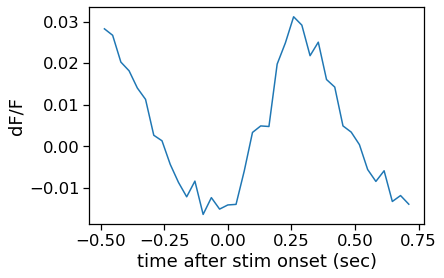

In [37]:
image_name = stim_response_df.image_name.unique()[6]
mean_trace = stim_response_df[(stim_response_df.cell_specimen_id==cell_specimen_id)&
                         (stim_response_df.image_name==image_name)].trace.mean()

plt.plot(times, mean_trace)
plt.xlabel('time after stim onset (sec)')
plt.ylabel('dF/F')


#### responsiveness

Response dataframes include other useful columns including <code>p_value_gray_screen</code> which compares the mean response for each trial to a shuffled distribution of values from the 5 min gray screen periods at the beginning and end of the session.

In [38]:
cell_data = stim_response_df[(stim_response_df.cell_specimen_id==cell_specimen_id)]
fraction_responsive = cell_data.p_value_gray_screen.mean()
print('this cell had a significant response for',fraction_responsive,'of all image presentations')

this cell had a significant response for 0.42011704521775367 of all image presentations


<code>p_value_omission</code> compares the mean response for each trial to a shuffled distribution of all omission responses

<code>p_value_stimulus</code> compares the mean response for each trial to a shuffled distribution of all other stimulus responses

### Get cell responses around change times for behavioral trials

In [39]:
# this creates a dataframe with the response of every cell for every behavioral trial (change and catch)
# cell response is a snippet of the trace in a [-5, 5] second window around change or catch time
trials_response_df = analysis.get_response_df(df_name='trials_response_df')

In [40]:
trials_response_df.head()

,trials_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,p_value_omission,p_value_stimulus,lick_times,...,stop_time,trial_length,behavioral_response_time,change_frame,change_time,behavioral_response_latency,initial_image_name,change_image_name,epoch,trial_type
0,1,992902634,"[-0.03815074026421763, 0.003048901828476412, 0...","[-4.9768954704012, -4.944577967346647, -4.9122...",0.002761,-0.015726,0.4574,0.2387,0.5810,"[312.93787406089467, 313.13803840090236, 313.2...",...,316.819476,8.757088,NaN,18390.0,312.625698,0.312176,im065,im077,0,auto_rewarded
1,1,992902619,"[0.09641908108815547, 0.09690868402531017, -0....","[-4.9768954704012, -4.944577967346647, -4.9122...",0.025997,-0.005630,0.1735,0.1118,0.1658,"[312.93787406089467, 313.13803840090236, 313.2...",...,316.819476,8.757088,NaN,18390.0,312.625698,0.312176,im065,im077,0,auto_rewarded
2,1,992902622,"[0.17414409762475988, 0.007017562703841254, 0....","[-4.9768954704012, -4.944577967346647, -4.9122...",-0.031675,-0.036975,0.9626,0.6955,0.9094,"[312.93787406089467, 313.13803840090236, 313.2...",...,316.819476,8.757088,NaN,18390.0,312.625698,0.312176,im065,im077,0,auto_rewarded
3,1,992902667,"[-0.058920901998085515, 0.0751975029666949, 0....","[-4.9768954704012, -4.944577967346647, -4.9122...",0.035122,-0.012737,0.0053,0.0116,0.0520,"[312.93787406089467, 313.13803840090236, 313.2...",...,316.819476,8.757088,NaN,18390.0,312.625698,0.312176,im065,im077,0,auto_rewarded
4,1,992902649,"[0.03973257094488493, -0.011916020009636069, 0...","[-4.9768954704012, -4.944577967346647, -4.9122...",0.013749,-0.005252,0.2381,0.1305,0.3664,"[312.93787406089467, 313.13803840090236, 313.2...",...,316.819476,8.757088,NaN,18390.0,312.625698,0.312176,im065,im077,0,auto_rewarded


In [41]:
trials_response_df.keys()

Index(['trials_id', 'cell_specimen_id', 'trace', 'trace_timestamps',
       'mean_response', 'baseline_response', 'p_value_gray_screen',
       'p_value_omission', 'p_value_stimulus', 'lick_times', 'reward_time',
       'reward_volume', 'hit', 'false_alarm', 'miss', 'stimulus_change',
       'aborted', 'go', 'catch', 'auto_rewarded', 'correct_reject',
       'start_time', 'stop_time', 'trial_length', 'behavioral_response_time',
       'change_frame', 'change_time', 'behavioral_response_latency',
       'initial_image_name', 'change_image_name', 'epoch', 'trial_type'],
      dtype='object')

Text(0, 0.5, 'dF/F')

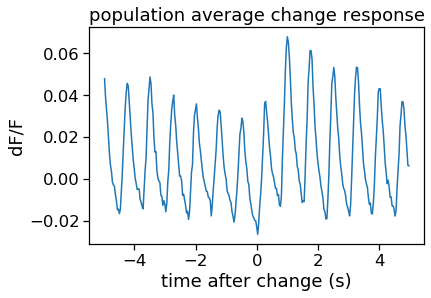

In [42]:
# popuation average response to image change
times = trials_response_df.trace_timestamps.values[0]
plt.plot(times, trials_response_df.trace.mean())
plt.title('population average change response')
plt.xlabel('time after change (s)')
plt.ylabel('dF/F')

### Get omission triggered responses 

In [43]:
# this creates a dataframe with the response of every cell for every omission
# cell response is a snippet of the trace in a [-.5, 0.75] second window around the omission time
omission_response_df = analysis.get_response_df(df_name='omission_response_df')

In [44]:
omission_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,p_value_omission,p_value_stimulus,duration,end_frame,image_index,image_name,omitted,start_frame,start_time,stop_time,change,epoch
0,13,992902634,"[0.06147743803837265, 0.09811394600566481, -0....","[-4.9768954704012, -4.944577967346647, -4.9122...",-0.022100,0.081356,0.9397,0.6861,0.8978,NaN,NaN,8,omitted,True,18570,315.611458,NaN,False,0
1,13,992902619,"[0.035646207486238396, 0.09467837212364097, -0...","[-4.9768954704012, -4.944577967346647, -4.9122...",0.004468,0.022521,0.4312,0.3168,0.4275,NaN,NaN,8,omitted,True,18570,315.611458,NaN,False,0
2,13,992902622,"[0.03751269891512046, 0.031581023467236055, -0...","[-4.9768954704012, -4.944577967346647, -4.9122...",-0.045896,0.105504,0.9986,0.7910,0.9679,NaN,NaN,8,omitted,True,18570,315.611458,NaN,False,0
3,13,992902667,"[0.0965439604768864, 0.08151458477178207, -0.0...","[-4.9768954704012, -4.944577967346647, -4.9122...",-0.010811,0.012836,0.8854,0.5734,0.8752,NaN,NaN,8,omitted,True,18570,315.611458,NaN,False,0
4,13,992902649,"[0.01413418952678909, 0.017499694952640088, -0...","[-4.9768954704012, -4.944577967346647, -4.9122...",-0.050514,-0.007053,0.9996,0.9497,0.9986,NaN,NaN,8,omitted,True,18570,315.611458,NaN,False,0


In [45]:
omission_response_df.keys()

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response',
       'p_value_gray_screen', 'p_value_omission', 'p_value_stimulus',
       'duration', 'end_frame', 'image_index', 'image_name', 'omitted',
       'start_frame', 'start_time', 'stop_time', 'change', 'epoch'],
      dtype='object')

Text(0, 0.5, 'dF/F')

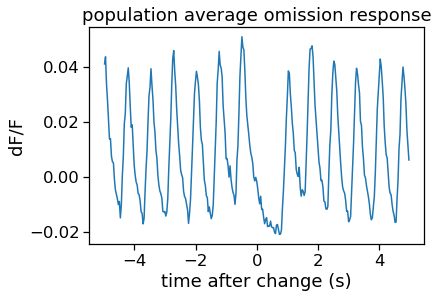

In [46]:
# popuation average response
times = omission_response_df.trace_timestamps.values[0]
plt.plot(times, omission_response_df.trace.mean())
plt.title('population average omission response')
plt.xlabel('time after change (s)')
plt.ylabel('dF/F')

### Get running behavior for omissions 

In [47]:
# similar functionality exist for pupil area

In [48]:
# this creates a dataframe with the running speed for every stimulus presentation
# trace is a snippet of the run speed in a [-.5, 0.75] second window around stim onset
run_speed_df = analysis.get_response_df(df_name='omission_run_speed_df')

In [49]:
run_speed_df.head()

,index,stimulus_presentations_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,p_value_omission,p_value_stimulus,duration,end_frame,image_index,image_name,omitted,start_frame,start_time,stop_time,change,epoch
0,0,13,"[-0.00016060630793646145, 0.5354614350559986, ...","[-4.987550032383085, -4.970869263044011, -4.95...",0.534435,0.103630,0.4292,0.4599,0.4350,NaN,NaN,8,omitted,True,18570,315.611458,NaN,False,0
1,2,16,"[-0.3437265019526322, 0.0, -1.032246505591008,...","[-4.987550032383085, -4.970869263044011, -4.95...",0.878759,0.606875,0.3966,0.3750,0.3477,NaN,NaN,8,omitted,True,18705,317.863278,NaN,False,0
2,4,65,"[-0.5682678530338965, 0.0, 0.26821311521739294...","[-4.987550032383085, -4.970869263044011, -4.95...",0.418636,0.565243,0.4499,0.4840,0.4823,NaN,NaN,8,omitted,True,20910,354.643648,NaN,False,0
3,6,83,"[4.498058470411964, 4.494026760860603, 4.67906...","[-4.987550032383085, -4.970869263044011, -4.95...",0.140254,0.278003,0.5925,0.6905,0.6702,NaN,NaN,8,omitted,True,21720,368.154328,NaN,False,0
4,8,112,"[-0.4557277514262342, -1.4477480731869061, -0....","[-4.987550032383085, -4.970869263044011, -4.95...",0.332757,-0.103283,0.4704,0.5363,0.5254,NaN,NaN,8,omitted,True,23025,389.922088,NaN,False,0


Text(0, 0.5, 'run speed (cm/s)')

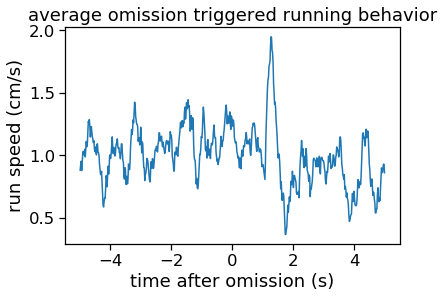

In [50]:
# running speed averaged across all omissions
times = run_speed_df.trace_timestamps.values[0]
plt.plot(times, run_speed_df.trace.mean())
plt.title('average omission triggered running behavior')
plt.xlabel('time after omission (s)')
plt.ylabel('run speed (cm/s)')

## get trial averaged response dataframe for some set of conditions 

VBA <code>response_analysis.utilities</code> has a function for averaging across trials for a given set of conditions: the <code>get_mean_df()</code> function

In [51]:
import visual_behavior.ophys.response_analysis.utilities as utilities

In [52]:
help(utilities.get_mean_df) # needs documentation...

Help on function get_mean_df in module visual_behavior.ophys.response_analysis.utilities:

get_mean_df(response_df, analysis=None, conditions=['cell', 'change_image_name'], flashes=False, omitted=False, get_reliability=True, get_pref_stim=True, exclude_omitted_from_pref_stim=True)



In [53]:
conditions = ['cell_specimen_id', 'image_name'] # conditions to groupby before averaging
mean_df = utilities.get_mean_df(stim_response_df, conditions=conditions, flashes=True)

must provide analysis object to get_mean_df to compute reliability


In [54]:
mean_df.head()

,cell_specimen_id,image_name,mean_response,sem_response,mean_trace,sem_trace,mean_responses,mean_baseline,sem_baseline,pref_stim,fraction_significant_p_value_gray_screen,fraction_significant_p_value_omission,fraction_significant_p_value_stimulus
0,992902610,im061,0.018958,0.001573,"[0.058872061780354444, 0.05138391212826471, 0....","[0.00370197924587146, 0.0034974144274466123, 0...","[0.0036268214358501734, 0.13944951742997472, 0...",-0.021492,0.001324,False,0.273345,0.421053,0.037351
1,992902610,im062,0.033404,0.002743,"[0.08306927150626427, 0.08526279749068161, 0.0...","[0.005519338900810428, 0.005177066580588507, 0...","[-0.02392596034673746, 0.00845526016713901, 0....",-0.019322,0.001996,True,0.379245,0.484906,0.133962
2,992902610,im063,0.007894,0.000866,"[0.027186728000039476, 0.018352709413017133, 0...","[0.002772098306642578, 0.0026699980707104933, ...","[0.008744712535756797, 0.020758640342032657, 0...",-0.011394,0.001081,False,0.114679,0.292049,0.001529
3,992902610,im065,0.022101,0.002025,"[0.0455716524699372, 0.04208194785666107, 0.04...","[0.004074824042247801, 0.00389590430182417, 0....","[0.006816229003447735, 0.034424611020797295, 0...",-0.020504,0.002048,False,0.310000,0.438333,0.048333
4,992902610,im066,0.018859,0.001694,"[0.0490406622024347, 0.0468189239810095, 0.037...","[0.003905212882222808, 0.003986599834452291, 0...","[0.00705282651318867, 0.11928168150913265, 0.0...",-0.018818,0.001688,False,0.298077,0.463462,0.036538


The resulting dataframe includes useful columns such as <code>pref_stim</code> which indicates the stimulus that evoked the maximal response across conditions for that cell, or  <code>fraction_significant_p_value_gray_screen</code> which tells you the fraction of trials for the given condition that had a significant p_value compared to the gray screen periods, or <code>mean_responses</code> which has an array of the mean response value for all trials of a given condition (useful for things like computing variability or noise correlations)

### plot mean trace for a cells preferred stimulus

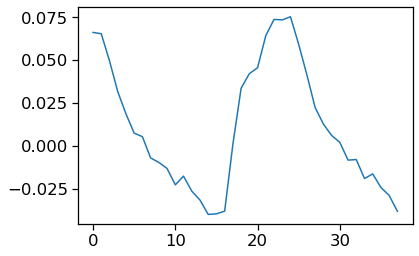

In [57]:
mean_trace = mean_df[(mean_df.cell_specimen_id==cell_specimen_id)&(mean_df.pref_stim==True)].mean_trace.values[0]
plt.plot(mean_trace)